In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline 

In [2]:
filename = '../colliders.csv'
data = np.loadtxt(filename,delimiter=',',dtype='Float64',skiprows=2)
TARGET_ALTITUDE = 5
SAFETY_DISTANCE = 5

In [3]:
import os, sys
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath('planning_utils.py'))))
import planning_utils

In [4]:
grid, north_offset, east_offset  = planning_utils.create_grid(data, TARGET_ALTITUDE, SAFETY_DISTANCE)

Objects found 3845, Point : [185.7611, 5.768500000000017]


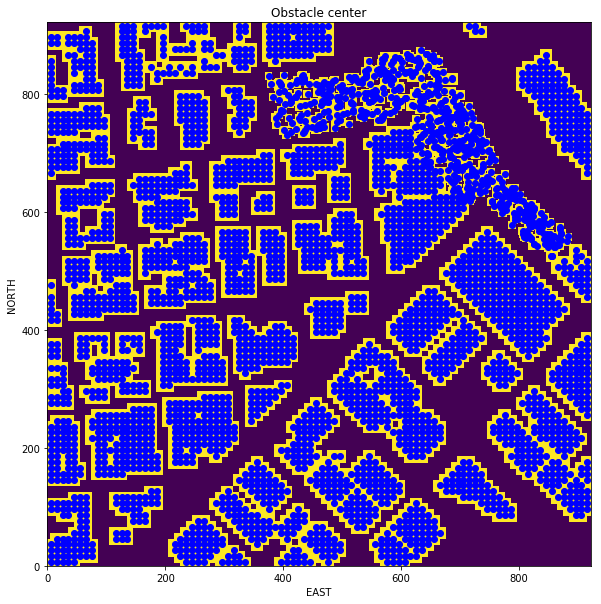

In [5]:
def get_object_centers(data, drone_altitude, safety_distance):
    """
    Returns a list of the obstacle centers.
    """
    points = []
    for i in range(data.shape[0]):
        north, east, alt, d_north, d_east, d_alt = data[i, :]
        if alt + d_alt + safety_distance > drone_altitude:
            points.append([north - north_offset, east - east_offset])
    return points;

obstacle_centers = get_object_centers(data, TARGET_ALTITUDE, SAFETY_DISTANCE)
print(f'Objects found {len(obstacle_centers)}, Point : {obstacle_centers[10]}')
fig = plt.figure(figsize=(20,10))
plt.imshow(grid, origin='lower') 
for north, east in obstacle_centers:
    plt.plot(east, north, 'bo')
plt.xlabel('EAST')
plt.ylabel('NORTH')
plt.title('Obstacle center')
plt.show()

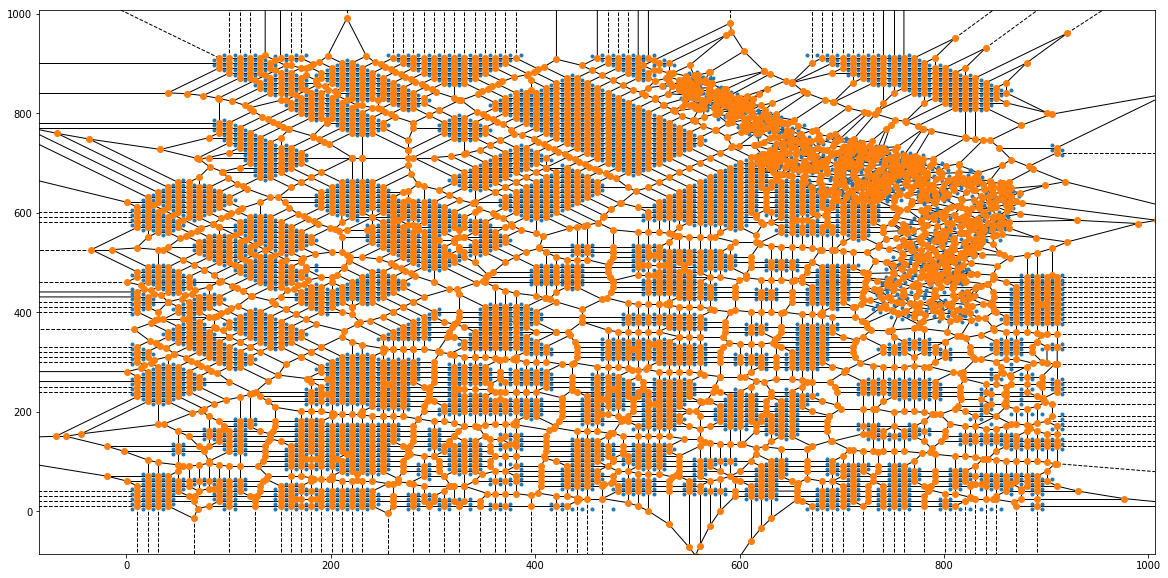

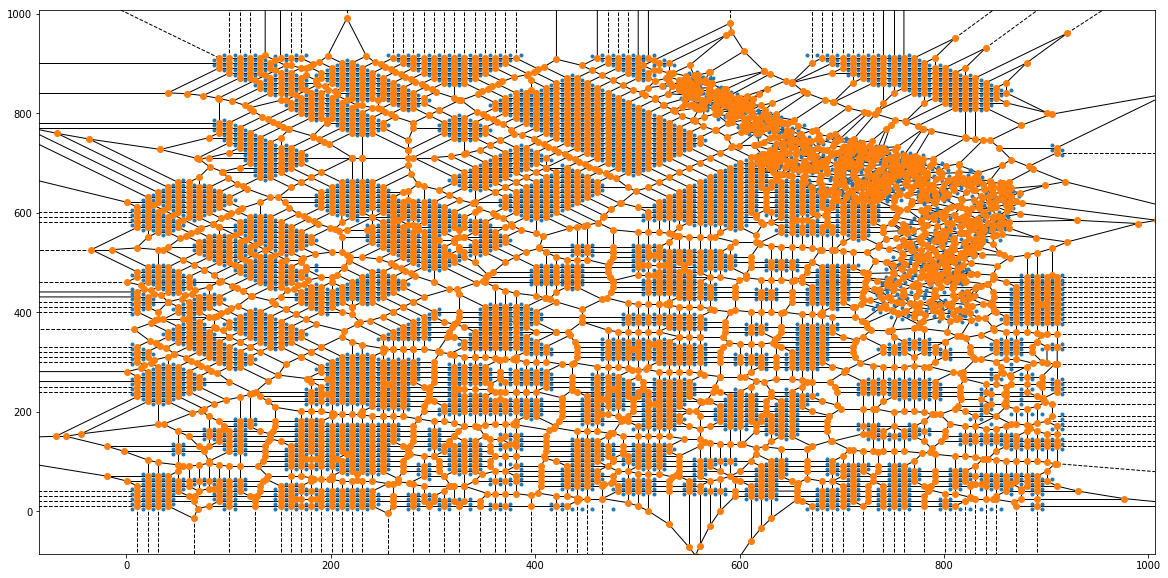

In [6]:
plt.rcParams["figure.figsize"] = [20,10]
from scipy.spatial import Voronoi, voronoi_plot_2d
test_graph_voronoi = Voronoi(obstacle_centers)
voronoi_plot_2d(test_graph_voronoi)

Voronoi edges count: 1419


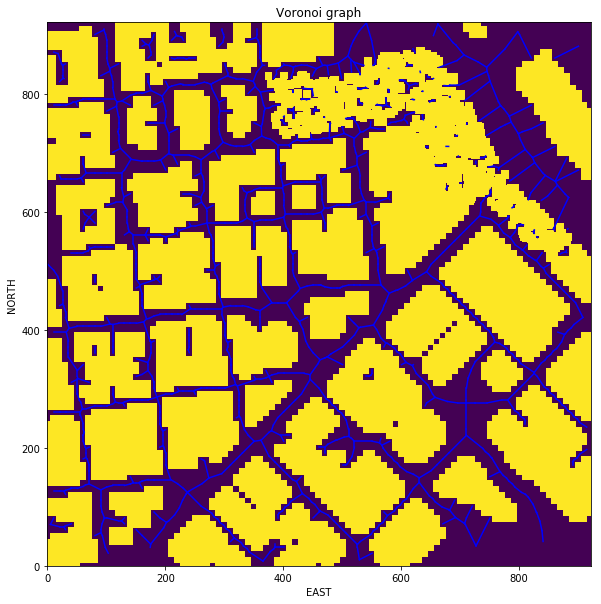

In [7]:
from bresenham import bresenham
def find_open_edges_voronoi(graph, grid):
    """
    Finds open edges from `graph` and `grid`
    """
    edges = []
    for v in graph.ridge_vertices:
        p1 = graph.vertices[v[0]]
        p2 = graph.vertices[v[1]]
        cells = list(bresenham(int(p1[0]), int(p1[1]), int(p2[0]), int(p2[1])))
        hit = False

        for c in cells:
            # First check if we're off the map
            if np.amin(c) < 0 or c[0] >= grid.shape[0] or c[1] >= grid.shape[1]:
                hit = True
                break
            # Next check if we're in collision
            if grid[c[0], c[1]] == 1:
                hit = True
                break

        # If the edge does not hit on obstacle
        # add it to the list
        if not hit:
            # array to tuple for future graph creation step)
            p1 = (p1[0], p1[1])
            p2 = (p2[0], p2[1])
            edges.append((p1, p2))
    return edges

test_edges_voronoi = find_open_edges_voronoi(test_graph_voronoi, grid)
print(f'Voronoi edges count: {len(test_edges_voronoi)}')
plt.imshow(grid, origin='lower') 

# Stepping through each edge
for e in test_edges_voronoi:
    p1 = e[0]
    p2 = e[1]
    plt.plot([p1[1], p2[1]], [p1[0], p2[0]], 'b-')

plt.xlabel('EAST')
plt.ylabel('NORTH')
plt.title('Voronoi graph')
plt.show()

In [8]:
from skimage.morphology import medial_axis
from skimage.util import invert

In [9]:
skeleton = medial_axis(invert(grid))

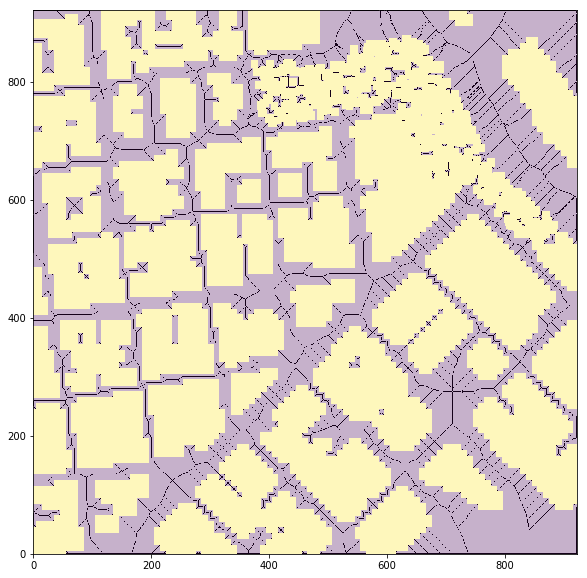

In [10]:
plt.imshow(grid, origin='lower') 
plt.imshow(skeleton, cmap='Greys', origin='lower', alpha=0.7)
plt.show()

In [11]:
import networkx as nx
import numpy.linalg as LA

In [12]:
def create_graph_from_edges(edges):
    """
    Create a graph from the `edges`
    """
    G = nx.Graph()
    for e in edges:
        p1 = e[0]
        p2 = e[1]
        dist = LA.norm(np.array(p2) - np.array(p1))
        G.add_edge(p1, p2, weight=dist)
    return G

test_graph = create_graph_from_edges(test_edges_voronoi)

In [13]:
from queue import PriorityQueue

def heuristic(n1, n2):
    return LA.norm(np.array(n2) - np.array(n1))

def a_star(graph, heuristic, start, goal):
    """Modified A* to work with NetworkX graphs."""
    
    path = []
    queue = PriorityQueue()
    queue.put((0, start))
    visited = set(start)

    branch = {}
    found = False
    
    while not queue.empty():
        item = queue.get()
        current_cost = item[0]
        current_node = item[1]

        if current_node == goal:        
            print('Found a path.')
            found = True
            break
        else:
            for next_node in graph[current_node]:
                cost = graph.edges[current_node, next_node]['weight']
                new_cost = current_cost + cost + heuristic(next_node, goal)
                
                if next_node not in visited:                
                    visited.add(next_node)               
                    queue.put((new_cost, next_node))
                    
                    branch[next_node] = (new_cost, current_node)
             
    path = []
    path_cost = 0
    if found:
        
        # retrace steps
        path = []
        n = goal
        path_cost = branch[n][0]
        path.append(goal)
        while branch[n][1] != start:
            path.append(branch[n][1])
            n = branch[n][1]
        path.append(branch[n][1])
            
    return path[::-1], path_cost

In [14]:
from udacidrone.frame_utils import global_to_local, local_to_global

In [15]:
global_home = np.array([-122.39745, 37.79248, 0.0])
global_position = np.array([-122.3974512, 37.7924799, 0.147])
local_position = global_to_local(global_position, global_home)
map_adjustment = np.array([north_offset, east_offset, .0])
local_position -= map_adjustment
print(f'Local position: {local_position}')
goals = np.array([[-122.39292549, 37.7902035, -0.147],
                 [-122.39287756, 37.79606176, -0.147],
                 [-122.40199327, 37.79245808, -0.147],
                 [-122.40195876,37.79673913, -0.147]])

# another one -122.398013, 37.795345
local_goals = list(map(lambda g: global_to_local(np.array([g[0], g[1], g[2]]), global_home), goals))
local_goals = list(map(lambda g: g - map_adjustment, local_goals))

Local position: [ 3.15988224e+02  4.44894417e+02 -1.47000000e-01]


In [16]:
def closest_point(graph, current_point):
    """
    Compute the closest point in the `graph`
    to the `current_point`.
    """
    closest_point = None
    dist = 100000
    for p in graph.nodes:
        d = LA.norm(np.array(p) - np.array(current_point))
        if d < dist:
            closest_point = p
            dist = d
    return closest_point

In [17]:
graph_start = closest_point(test_graph, (local_position[0], local_position[1]))
graph_goals = list(map(lambda g: closest_point(test_graph, (g[0], g[1])), local_goals))

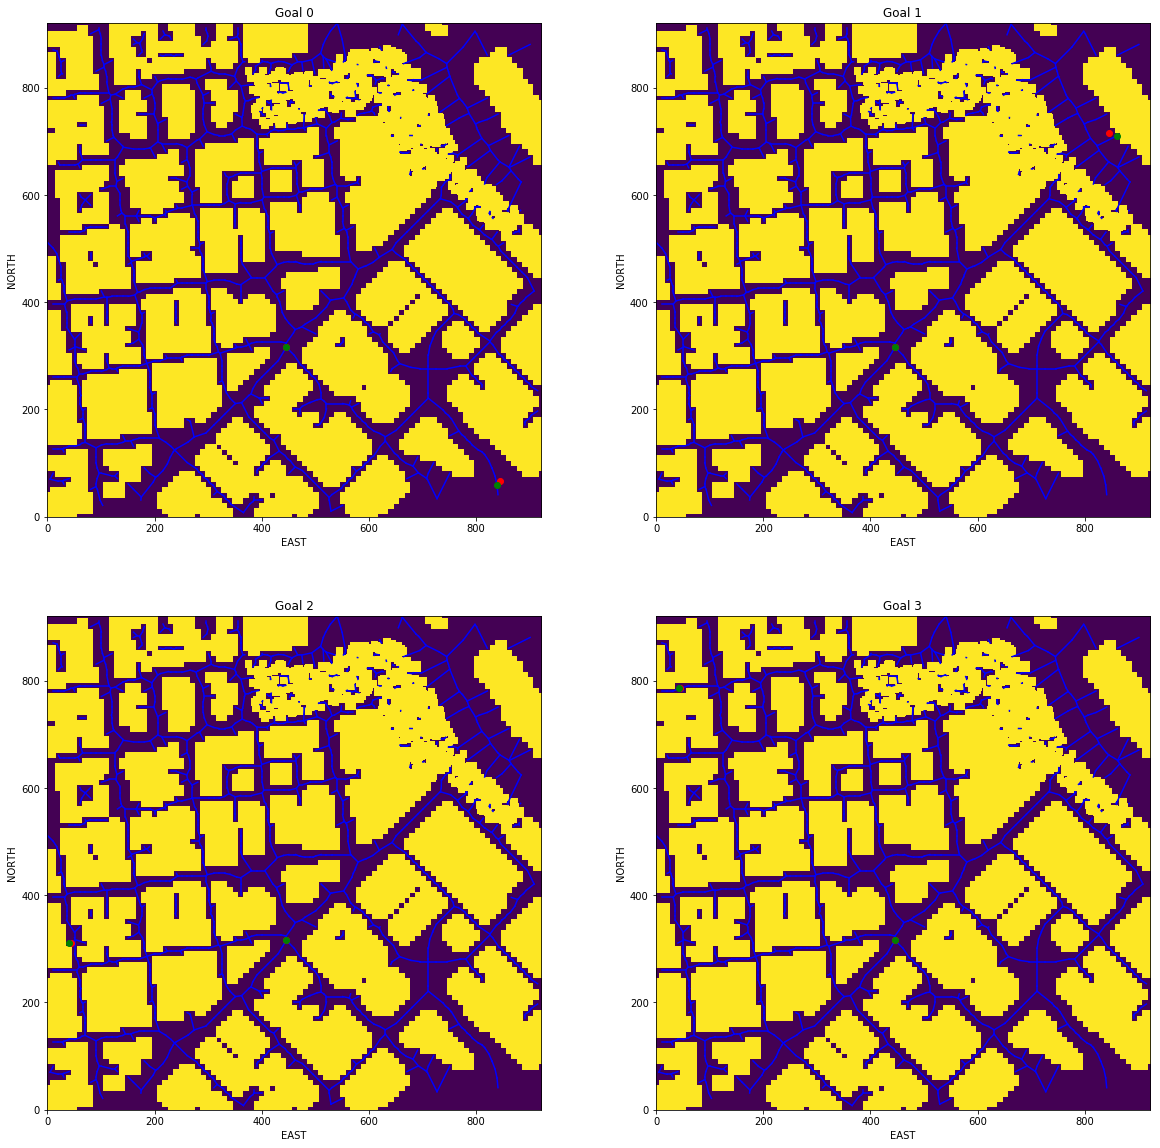

In [18]:
fig, axes = plt.subplots(2, 2, figsize=(20,20))
for index, ax, local_goal, graph_goal in zip(range(4), axes.flat, local_goals, graph_goals):
    ax.imshow(grid, origin='lower') 
    for e in test_edges_voronoi:
        p1 = e[0]
        p2 = e[1]
        ax.plot([p1[1], p2[1]], [p1[0], p2[0]], 'b-')

    ax.plot(local_position[1], local_position[0], 'ro')
    ax.plot(graph_start[1], graph_start[0], 'go')
    ax.plot(local_goal[1], local_goal[0], 'ro')
    ax.plot(graph_goal[1], graph_goal[0], 'go')
    ax.set_xlabel('EAST')
    ax.set_ylabel('NORTH')
    ax.set_title(f'Goal {index}')

Found a path.
Found a path.
Found a path.


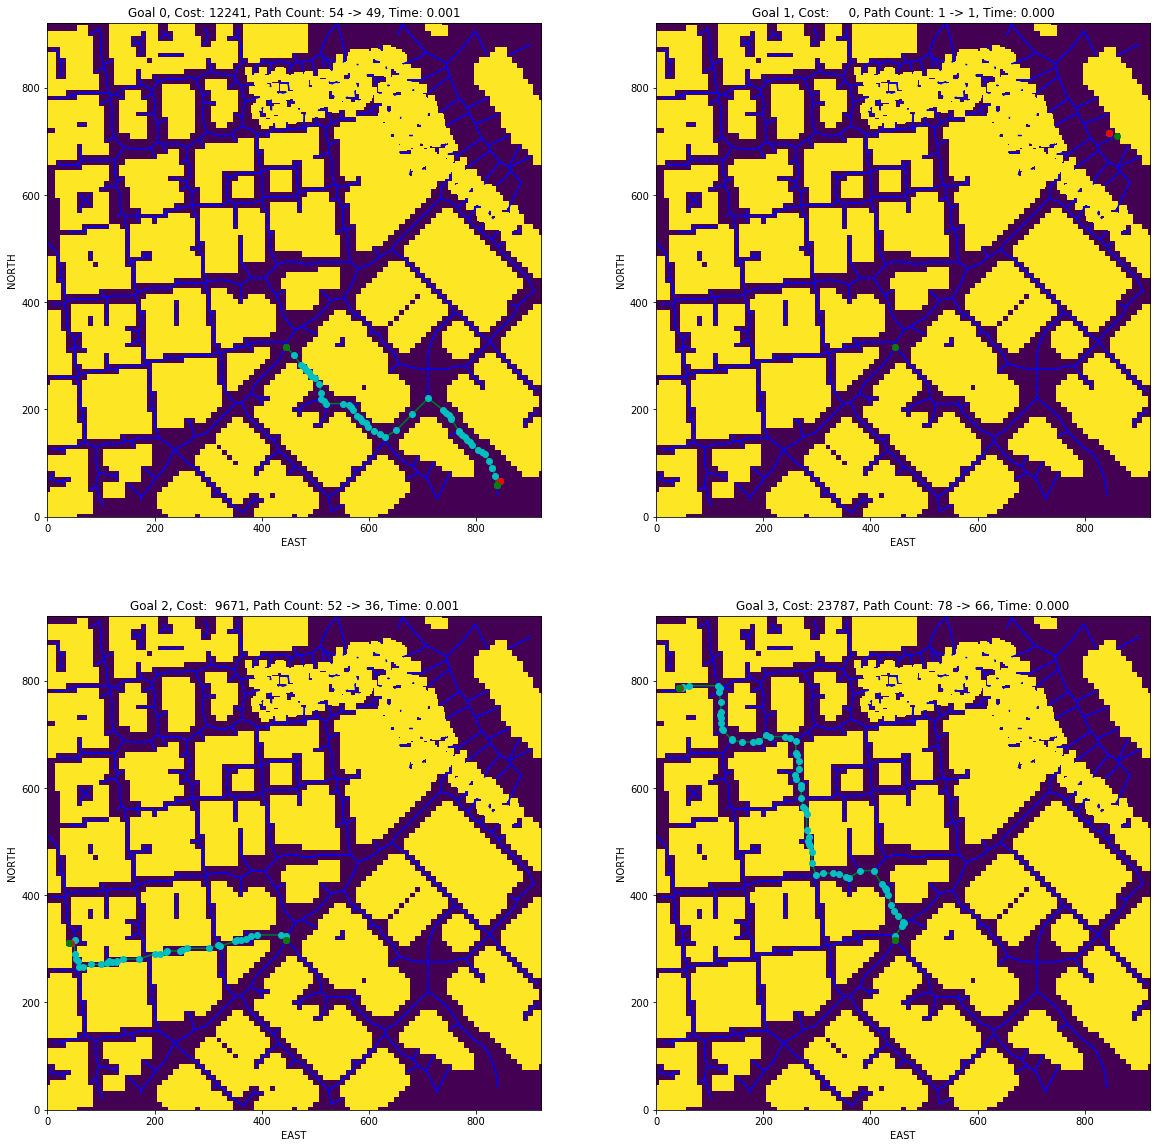

In [24]:

import time
fig, axes = plt.subplots(2, 2, figsize=(20,20))
for index, ax, local_goal, graph_goal in zip(range(4), axes.flat, local_goals, graph_goals):
    start = time.time()
    
    end = time.time()
    time_spam = (end - start) * 1000
    path, cost = a_star(test_graph, heuristic, graph_start, graph_goal)
    path.append(local_goal)
    
    waypoints_count = len(path)
    
    path = planning_utils.collinearity_prune(path, epsilon=1e-3)
    
    waypoints = np.array([[p[0], p[1], TARGET_ALTITUDE, 0] for p in path])
    
    ax.imshow(grid, origin='lower') 
    for e in test_edges_voronoi:
        p1 = e[0]
        p2 = e[1]
        ax.plot([p1[1], p2[1]], [p1[0], p2[0]], 'b-')

    path = planning_utils.collinearity_prune(path, epsilon=1e-3)
    
    wp_count_display = f'{waypoints_count} -> {len(path)}'
    
    ax.plot(waypoints[:, 1], waypoints[:, 0], 'g')
    ax.plot(waypoints[:, 1], waypoints[:, 0], 'oc')
    
    ax.plot(local_position[1], local_position[0], 'ro')
    ax.plot(graph_start[1], graph_start[0], 'go')
    ax.plot(local_goal[1], local_goal[0], 'ro')
    ax.plot(graph_goal[1], graph_goal[0], 'go')
    ax.set_xlabel('EAST')
    ax.set_ylabel('NORTH')
    ax.set_title(f'Goal {index}, Cost: {cost:5.0f}, Path Count: {wp_count_display}, Time: {time_spam:2.3f}')